## Shortlist Promising Models - SGD Classifier

#### 0. Import modules and define parameters

In [1]:
import sys
sys.path.append("..")

import general_utils
import data_prepare_utils
import bin_class_utils
from sklearn.pipeline import Pipeline
import time
import pandas as pd

In [2]:
start = time.time()

In [3]:
TRAIN_FILE_PATH = "./data/train_df.csv"
VALIDATION_FILE_PATH = "./data/validation_df.csv"

TARGET_ATTR = "label"
TARGET_TYPE = "binary"

ESTIMATOR_NAME = "SGDClassifier"

SAMPLE_SIZE = 0.05
SAMPLE_RANDOM_STATE = 24
TARGET_ENCODING_RANDOM_STATE = 42
MODEL_RANDOM_STATE = 42
PERMUTATION_IMPORTANCE_RANDOM_STATE = 0

ATTRS_TO_DROP = ['uid', 'app_score', 'his_on_shelf_time', 'task_id', 'spread_app_id', 'tags', 'dev_id']

CVS_SCORING_LIST = ['accuracy', 'precision', 'recall', 'f1']
PERMUTATION_SCORING_LIST = ['average_precision', 'roc_auc']
PERM_DROP_THRESHOLD_PERCENT = 0.15

#### 1. Import Data

In [4]:
train_df = general_utils.read_csv(TRAIN_FILE_PATH)


Read CSV file ../data/train_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1920544,3854,3367,7,207,17,5,11,13,37,...,4,20,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0
1,1850503,3903,6370,7,173,52,5,12,69,11,...,2,-1,-1,-1,2,5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^...,12,50,7,0
2,2157496,1847,6428,6,178,17,5,18,70,39,...,7,20,1,-1,9,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,7,0
3,2072043,4125,4468,7,168,37,5,12,44,40,...,2,20,-1,-1,2,6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,11,17,6,0
4,1084626,4811,3326,7,183,29,5,12,86,37,...,3,18,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0


df.shape: (670513, 36)


#### 2. Sample smaller training sets for fast exploration

In [5]:
train_df_sample = data_prepare_utils.sample_data(train_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del train_df


Sample 0.05 fraction from DataFrame:
sample_df.shape: (33525, 36)


#### 3. Check attribute types

In [6]:
numerical_attr_list = []
categorical_attr_list = [attr for attr in train_df_sample.columns if attr not in numerical_attr_list and attr != TARGET_ATTR]
attr_list = numerical_attr_list + categorical_attr_list
attr_list

['uid',
 'task_id',
 'adv_id',
 'creat_type_cd',
 'adv_prim_id',
 'dev_id',
 'inter_type_cd',
 'slot_id',
 'spread_app_id',
 'tags',
 'app_first_class',
 'app_second_class',
 'age',
 'city',
 'city_rank',
 'device_name',
 'device_size',
 'career',
 'gender',
 'net_type',
 'residence',
 'his_app_size',
 'his_on_shelf_time',
 'app_score',
 'emui_dev',
 'list_time',
 'device_price',
 'up_life_duration',
 'up_membership_grade',
 'membership_life_duration',
 'consume_purchase',
 'communication_onlinerate',
 'communication_avgonline_30d',
 'indu_name',
 'pt_d']

#### 4. Predefined data processing strategy in prep.ipynb

In [7]:
train_df_sample = data_prepare_utils.drop_duplicate_obs(train_df_sample)


Drop duplicate observations:
df.shape:  (33525, 36)
drop_dup_df.shape:  (33519, 36)


In [8]:
preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, ATTRS_TO_DROP, TARGET_TYPE, TARGET_ENCODING_RANDOM_STATE)
preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('column_dropper',
                                                  DropColumnsTransformer(attrs_to_drop=['uid',
                                                                                        'app_score',
                                                                                        'his_on_shelf_time',
                                                                                        'task_id',
                                                                                        'spread_app_id',
                                                                                        'tags',
                                                                                        'dev_id'])),
                                                 ('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 []),
                                ('categorical',
                                 Pipeline(steps=[('column_dropper',
                                                  DropColumnsTransformer(attrs_to_drop=['...
                                  'adv_prim_id', 'dev_id', 'inter_type_cd',
                                  'slot_id', 'spread_app_id', 'tags',
                                  'app_first_class', 'app_second_class', 'age',
                                  'city', 'city_rank', 'device_name',
                                  'device_size', 'career', 'gender', 'net_type',
                                  'residence', 'his_app_size',
                                  'his_on_shelf_time', 'app_score', 'emui_dev',
                                  'list_time', 'device_price',
                                  'up_life_duration', 'up_membership_grade',
                                  'membership_life_duration', ...])])

#### 5. Define default model

In [9]:
estimator = bin_class_utils.get_default_model(ESTIMATOR_NAME, MODEL_RANDOM_STATE)
estimator

SGDClassifier(class_weight='balanced', loss='log_loss', max_iter=10000,
              random_state=42)

#### 6. Define composite model

In [10]:
composite_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('estimator', estimator)
])
composite_estimator

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['uid',
                                                                                                         'app_score',
                                                                                                         'his_on_shelf_time',
                                                                                                         'task_id',
                                                                                                         'spread_app_id',
                                                                                                         'tags',
                                                                                                         'dev_id'])),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('categorical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropCol...
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator',
                 SGDClassifier(class_weight='balanced', loss='log_loss',
                               max_iter=10000, random_state=42))])

In [11]:
train_cap_x_df, train_y_df = train_df_sample.drop(columns=TARGET_ATTR), train_df_sample[[TARGET_ATTR]]
del train_df_sample

In [12]:
composite_estimator.fit(
    train_cap_x_df,
    train_y_df.values.ravel()
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['uid',
                                                                                                         'app_score',
                                                                                                         'his_on_shelf_time',
                                                                                                         'task_id',
                                                                                                         'spread_app_id',
                                                                                                         'tags',
                                                                                                         'dev_id'])),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('categorical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropCol...
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator',
                 SGDClassifier(class_weight='balanced', loss='log_loss',
                               max_iter=10000, random_state=42))])

#### 7. Evaluate model performance on train set

Evaluate the trained estimator performance on train sample set
Check accuracy score
train sample set accuracy score: 0.687252006324771

Check classification report
{'0': {'precision': 0.976314872866597, 'recall': 0.6928900287365201, 'f1-score': 0.8105402035025573, 'support': 32363.0}, '1': {'precision': 0.05800398066533978, 'recall': 0.5294117647058824, 'f1-score': 0.10455283163919024, 'support': 1156.0}, 'accuracy': 0.687252006324771, 'macro avg': {'precision': 0.5171594267659684, 'recall': 0.6111508967212012, 'f1-score': 0.4575465175708738, 'support': 33519.0}, 'weighted avg': {'precision': 0.9446442564584507, 'recall': 0.687252006324771, 'f1-score': 0.7861921799375926, 'support': 33519.0}}

Check confusion matrix
train sample set confusion matrix: 
[[22424  9939]
 [  544   612]]
True Positives =  22424
True Negatives =  612
False Positives(Type I error) =  9939
False Negatives(Type II error) =  544

Check cross validation score

accuracy scores: [0.57965394 0.47434368 0.54609189 0.5

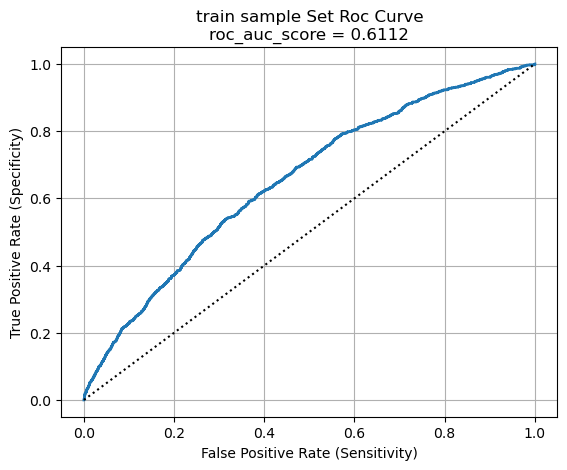


Check Precision-Recall Curve and Average Precision Score


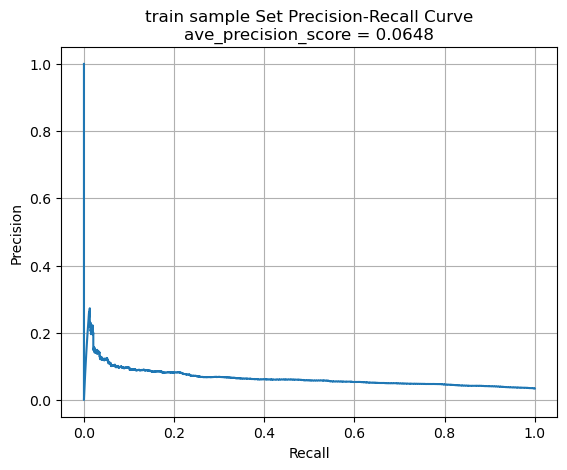

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,train sample,0.6873,0.058004,0.529412,0.5468,0.0457,0.6064,0.0849,0.6112


In [13]:
eval_train_results = bin_class_utils.eval_class(train_cap_x_df, train_y_df, composite_estimator, "train sample", CVS_SCORING_LIST)
eval_train_results

#### 8. Read in and sample validation data set

In [14]:
validation_df = general_utils.read_csv(VALIDATION_FILE_PATH)


Read CSV file ../data/validation_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1451378,2082,3033,7,154,56,5,11,31,40,...,4,20,-1,-1,7,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,17,5,0
1,1619957,1225,4676,7,178,17,5,17,70,39,...,4,20,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,6,0
2,1698084,2206,2822,7,177,56,5,14,31,40,...,5,20,1,-1,2,-1,-1,17,3,0
3,1983802,5103,2564,7,151,60,4,12,23,26,...,4,20,-1,-1,8,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,39,5,0
4,1537560,1098,1732,7,134,55,4,17,65,18,...,4,20,-1,-1,2,3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20...,12,14,1,0


df.shape: (167629, 36)


In [15]:
validation_df_sample = data_prepare_utils.sample_data(validation_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del validation_df


Sample 0.05 fraction from DataFrame:
sample_df.shape: (8381, 36)


In [16]:
validation_cap_x_df, validation_y_df = validation_df_sample.drop(columns=TARGET_ATTR), validation_df_sample[[TARGET_ATTR]]
del validation_df_sample

#### 9. Evaluate model performance on validation set

Evaluate the trained estimator performance on validation sample set
Check accuracy score
validation sample set accuracy score: 0.6852404247703138

Check classification report
{'0': {'precision': 0.9726169844020798, 'recall': 0.6935244686109738, 'f1-score': 0.8096955706247295, 'support': 8092.0}, '1': {'precision': 0.050172347759479125, 'recall': 0.4532871972318339, 'f1-score': 0.09034482758620688, 'support': 289.0}, 'accuracy': 0.6852404247703138, 'macro avg': {'precision': 0.5113946660807794, 'recall': 0.5734058329214039, 'f1-score': 0.4500201991054682, 'support': 8381.0}, 'weighted avg': {'precision': 0.9408085486557831, 'recall': 0.6852404247703138, 'f1-score': 0.7848903725889185, 'support': 8381.0}}

Check confusion matrix
validation sample set confusion matrix: 
[[5612 2480]
 [ 158  131]]
True Positives =  5612
True Negatives =  131
False Positives(Type I error) =  2480
False Negatives(Type II error) =  158

Check cross validation score

accuracy scores: [0.61001789 0.55310263 0.4

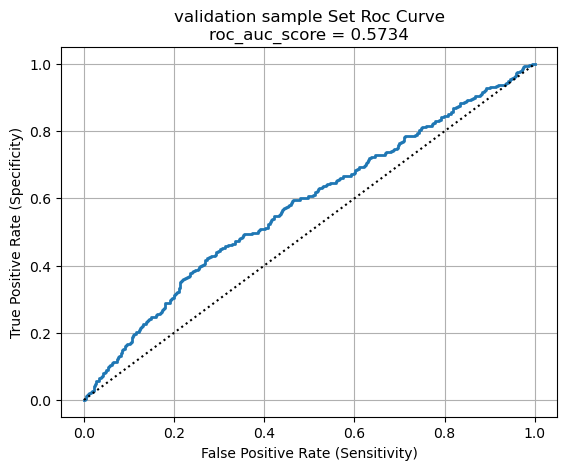


Check Precision-Recall Curve and Average Precision Score


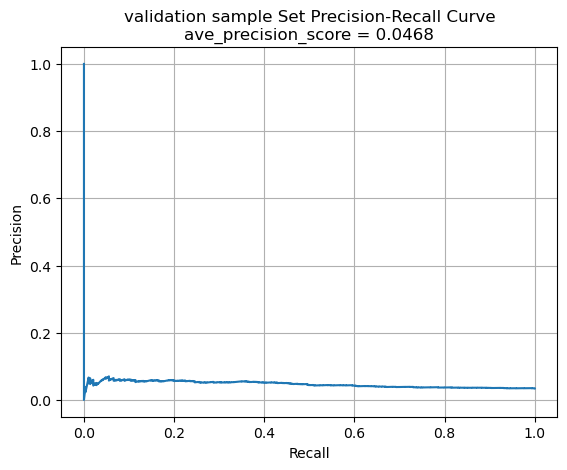

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,validation sample,0.6852,0.050172,0.453287,0.5531,0.0444,0.5746,0.0823,0.5734


In [17]:
eval_validation_results = bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, composite_estimator, "validation sample", CVS_SCORING_LIST)
eval_validation_results

#### 10. Check the most significant attributes

In [18]:
perm_results_df = bin_class_utils.check_out_permutation_importance(
    composite_estimator, 
    train_cap_x_df, 
    train_y_df, 
    PERMUTATION_IMPORTANCE_RANDOM_STATE,
    PERMUTATION_SCORING_LIST
)
perm_results_df


Check out permutation importance:


,metric_name,feature_name,metric_mean,metric_std_dev
0,average_precision,adv_id,0.020945,0.000338
1,average_precision,slot_id,0.018599,0.000785
2,average_precision,his_app_size,0.008557,0.000639
3,average_precision,app_first_class,0.008095,0.000767
4,average_precision,emui_dev,0.002821,0.000375
5,average_precision,residence,0.002556,0.000454
6,average_precision,device_name,0.001781,0.000218
7,average_precision,communication_onlinerate,0.001639,0.000186
8,average_precision,device_size,0.001557,0.000187
9,average_precision,city_rank,0.001319,0.000246


#### 11. Feature selection and engineering

In [19]:
common_least_important_attrs = bin_class_utils.drop_least_important_attrs(perm_results_df, PERM_DROP_THRESHOLD_PERCENT)
common_least_important_attrs

['indu_name',
 'creat_type_cd',
 'emui_dev',
 'residence',
 'city_rank',
 'communication_onlinerate',
 'device_name',
 'consume_purchase',
 'device_size']

#### 12. Fit and evaluate again

In [20]:
attrs_to_drop_exp = list(set(ATTRS_TO_DROP + common_least_important_attrs))
attrs_to_drop_exp

['spread_app_id',
 'indu_name',
 'creat_type_cd',
 'emui_dev',
 'residence',
 'city_rank',
 'tags',
 'communication_onlinerate',
 'his_on_shelf_time',
 'app_score',
 'device_name',
 'dev_id',
 'consume_purchase',
 'task_id',
 'uid',
 'device_size']

In [21]:
preprocessor_exp = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, attrs_to_drop_exp, TARGET_TYPE, TARGET_ENCODING_RANDOM_STATE)

estimator_exp = bin_class_utils.get_default_model(ESTIMATOR_NAME, MODEL_RANDOM_STATE)

composite_estimator_exp = Pipeline(steps=[
    ('preprocessor', preprocessor_exp), 
    ('estimator', estimator_exp)
])

In [22]:
composite_estimator_exp.fit(
    train_cap_x_df,
    train_y_df.values.ravel()
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['spread_app_id',
                                                                                                         'indu_name',
                                                                                                         'creat_type_cd',
                                                                                                         'emui_dev',
                                                                                                         'residence',
                                                                                                         'city_rank',
                                                                                                         'tags',
                                                                                                         'communication_onlinerate',
                                                                                                         'his_on_shelf_time',
                                                                                                         'app_score',
                                                                                                         'device_name',
                                                                                                         'dev_id',
                                                                                                         'consume_purchase',
                                                                                                         'task_id',
                                                                                                         'uid...
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator',
                 SGDClassifier(class_weight='balanced', loss='log_loss',
                               max_iter=10000, random_state=42))])

Evaluate the trained estimator performance on train sample exp set
Check accuracy score
train sample exp set accuracy score: 0.5561323428503236

Check classification report
{'0': {'precision': 0.981229702207299, 'recall': 0.5508142014028365, 'f1-score': 0.7055610528398972, 'support': 32363.0}, '1': {'precision': 0.05308754559666493, 'recall': 0.7050173010380623, 'f1-score': 0.09874000484613521, 'support': 1156.0}, 'accuracy': 0.5561323428503236, 'macro avg': {'precision': 0.517158623901982, 'recall': 0.6279157512204494, 'f1-score': 0.4021505288430162, 'support': 33519.0}, 'weighted avg': {'precision': 0.9492200261118936, 'recall': 0.5561323428503236, 'f1-score': 0.6846330677722999, 'support': 33519.0}}

Check confusion matrix
train sample exp set confusion matrix: 
[[17826 14537]
 [  341   815]]
True Positives =  17826
True Negatives =  815
False Positives(Type I error) =  14537
False Negatives(Type II error) =  341

Check cross validation score

accuracy scores: [0.5299821  0.43720167

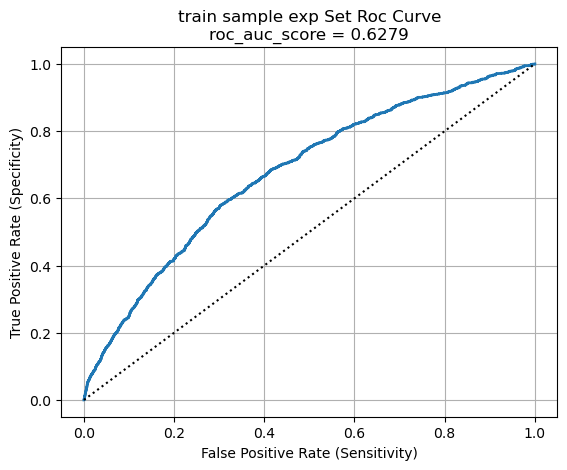


Check Precision-Recall Curve and Average Precision Score


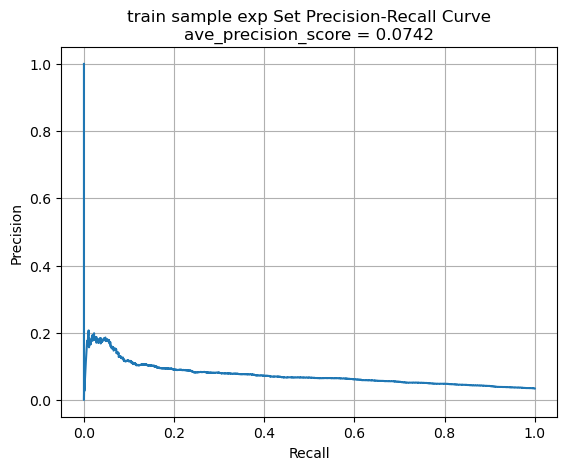

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,train sample exp,0.5561,0.053088,0.705017,0.5464,0.0474,0.6229,0.088,0.6279


In [23]:
eval_train_exp_results = bin_class_utils.eval_class(train_cap_x_df, train_y_df, composite_estimator_exp, "train sample exp", CVS_SCORING_LIST)
eval_train_exp_results

Evaluate the trained estimator performance on validation sample exp set
Check accuracy score
validation sample exp set accuracy score: 0.5579286481326811

Check classification report
{'0': {'precision': 0.9771590167500543, 'recall': 0.5551161641127039, 'f1-score': 0.7080148159823468, 'support': 8092.0}, '1': {'precision': 0.048625792811839326, 'recall': 0.6366782006920415, 'f1-score': 0.09035109256076602, 'support': 289.0}, 'accuracy': 0.5579286481326811, 'macro avg': {'precision': 0.5128924047809469, 'recall': 0.5958971824023727, 'f1-score': 0.3991829542715564, 'support': 8381.0}, 'weighted avg': {'precision': 0.9451406297177021, 'recall': 0.5579286481326811, 'f1-score': 0.686716066898844, 'support': 8381.0}}

Check confusion matrix
validation sample exp set confusion matrix: 
[[4492 3600]
 [ 105  184]]
True Positives =  4492
True Negatives =  184
False Positives(Type I error) =  3600
False Negatives(Type II error) =  105

Check cross validation score

accuracy scores: [0.47406082 0.6

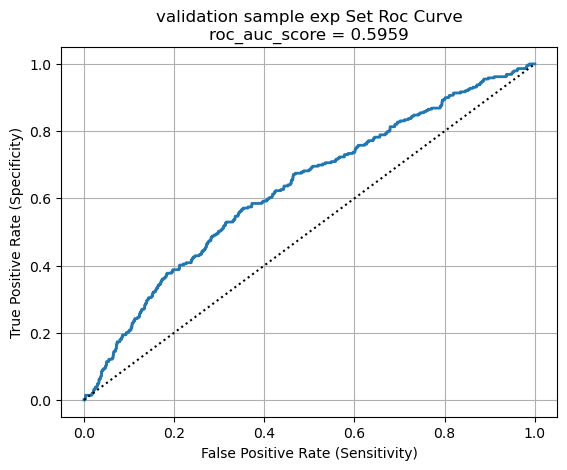


Check Precision-Recall Curve and Average Precision Score


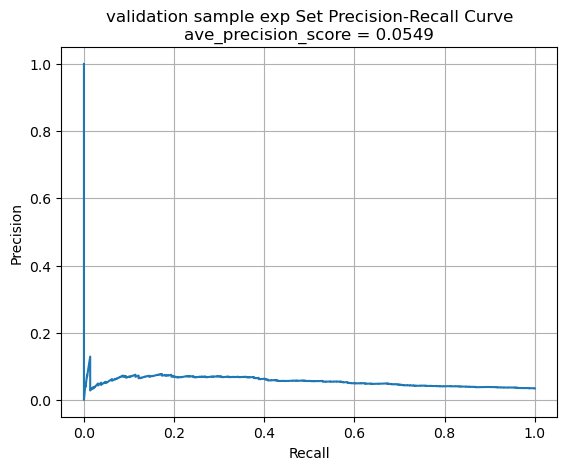

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,validation sample exp,0.5579,0.048626,0.636678,0.589,0.0431,0.516,0.0792,0.5959


In [24]:
eval_validation_exp_results = bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, composite_estimator_exp, "validation sample exp", CVS_SCORING_LIST)
eval_validation_exp_results

#### 13. Decide attrs to drop for fine-tuning

In [25]:
compare_df = pd.concat([eval_train_results, eval_validation_results, eval_train_exp_results, eval_validation_exp_results], axis=0)
compare_df

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,train sample,0.6873,0.058004,0.529412,0.5468,0.0457,0.6064,0.0849,0.6112
0,validation sample,0.6852,0.050172,0.453287,0.5531,0.0444,0.5746,0.0823,0.5734
0,train sample exp,0.5561,0.053088,0.705017,0.5464,0.0474,0.6229,0.0880,0.6279
0,validation sample exp,0.5579,0.048626,0.636678,0.5890,0.0431,0.5160,0.0792,0.5959


- The model performance after dropping some common least important features in permutation importance test show improvements in specific performance metrics. On validation data set, the new model has a slightly higher `recall score` and mean of `precision scores`. However, `accuracy score` has decreased. It indicates that the new model performs better in correcty identifying positive instances on average but sacrifices accuracy (a higher number of misclassifications overall). 
- `false positives` increases after dropping some features, indicating a higher Type I errors.
- Because minimizing `false positives` is crucial, we would **not** apply the new drop list in the fine-tuning stage.

In [26]:
attrs_to_drop_for_fine_tuning = attrs_to_drop_exp

attrs_to_drop_for_fine_tuning

['spread_app_id',
 'indu_name',
 'creat_type_cd',
 'emui_dev',
 'residence',
 'city_rank',
 'tags',
 'communication_onlinerate',
 'his_on_shelf_time',
 'app_score',
 'device_name',
 'dev_id',
 'consume_purchase',
 'task_id',
 'uid',
 'device_size']

In [27]:
end = time.time()
print(f'Script run time: {(end - start)/60} minutes')

Script run time: 4.494809933503469 minutes
